## Demo of taming instabilities in regression problems using Ridge & Lasso regularization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os


from disp import set_plot  # custom func for adjusting plot params

np.random.seed(1)  # set RNG seed

if not os.path.exists('20220510_handling_correlated_predictors'):
    os.makedirs('20220510_handling_correlated_predictors')

Generate predictors

$$x_1 \sim \mathcal{N}(x_1; \mu, \sigma^2) \quad \quad \quad x_2 = 2x_1 + \eta_x$$

($\eta_x$ is a weak noise process).

and target

$$y = x_1 + x_2 + \eta_y = \mathbf{w}^T\mathbf{x}$$

($\eta_y$ is a [not necessarily weak] noise process). $\mathbf{w}^T = (1, 1)$.

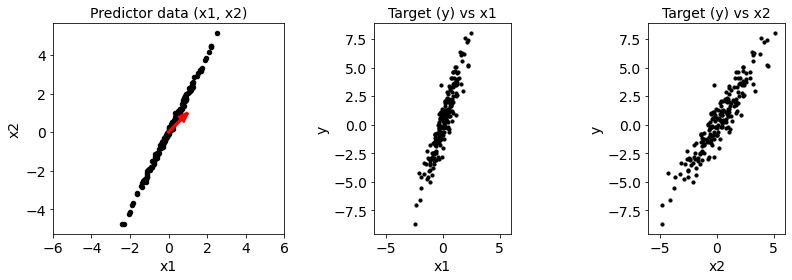

In [2]:
n = 200

# create data
x_1 = np.random.randn(n)
x_2 = 2*x_1 + .1*np.random.randn(n)

y = x_1 + x_2 + np.random.randn(n)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
axs[0].scatter(x_1, x_2, c='k', s=20)
axs[0].arrow(0, 0, 1, 1, color='r', lw=3, length_includes_head=True, head_width=.3)
axs[0].set_aspect('equal')
set_plot(axs[0], x_lim=(-6, 6), x_label='x1', y_label='x2', title='Predictor data (x1, x2)', font_size=14)

axs[1].scatter(x_1, y, c='k', s=10)
axs[1].set_aspect('equal')
set_plot(axs[1], x_lim=(-6, 6), x_label='x1', y_label='y', title=r'Target (y) vs x1', font_size=14)

axs[2].scatter(x_2, y, c='k', s=10)
axs[2].set_aspect('equal')
set_plot(axs[2], x_lim=(-6, 6), x_label='x2', y_label='y', title=r'Target (y) vs x2', font_size=14)

fig.savefig('20220510_handling_correlated_predictors/data.svg')

Use sklearn to estimate weights from target and predictors.

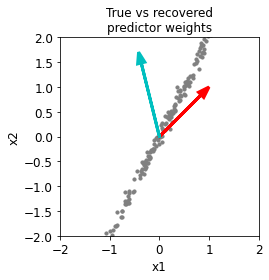

In [3]:
# matrix version of predictors
x_mat = np.nan*np.zeros((n, 2))
x_mat[:, 0] = x_1
x_mat[:, 1] = x_2


# fit vanilla linear regression model
from sklearn import linear_model

rgr = linear_model.LinearRegression().fit(x_mat, y)

w_hat = rgr.coef_  # weight estimate

fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(x_1, x_2, c='gray', s=10)
ax.arrow(0, 0, 1, 1, color='r', lw=3, length_includes_head=True, head_width=.15)
ax.arrow(0, 0, w_hat[0], w_hat[1], color='c', lw=3, length_includes_head=True, head_width=.15)
ax.set_aspect('equal')

set_plot(ax, x_lim=(-2, 2), y_lim=(-2, 2), x_label='x1', y_label='x2', title='True vs recovered\npredictor weights', font_size=12)

fig.savefig('20220510_handling_correlated_predictors/example_recovered_weights.svg')

### 10 instantiations of weight estimates using vanilla (unregularized), ridge, and lasso regression

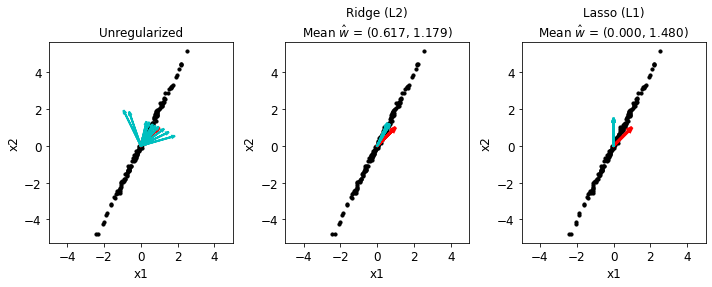

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5), tight_layout=True)

titles = ['Unregularized', 'Ridge (L2)', 'Lasso (L1)']
rgrs = [
    linear_model.LinearRegression(),
    linear_model.Ridge(alpha=10),
    linear_model.Lasso(alpha=.05),  # note Lasso & Ridge normalize loss func differently in sklearn, hence diff typical alpha ranges
]

for ax, title, rgr in zip(axs, titles, rgrs):
    ax.scatter(x_1, x_2, c='k', s=10)
    ax.arrow(0, 0, 1, 1, color='r', lw=3, length_includes_head=True, head_width=.15)

    w_hats = []  # weight estimates
    
    for ctr in range(10):  # loop over instantiations of target noise \eta_y
        y = x_1 + x_2 + np.random.randn(n)
        rgr.fit(x_mat, y)
        w_hat = rgr.coef_  # 
        
        ax.arrow(0, 0, w_hat[0], w_hat[1], color='c', lw=2, length_includes_head=True, head_width=.1)  # plot weight estimate
        w_hats.append(w_hat)  # store
    
    if title in titles[1:]:
        w_hat_mn = np.mean(w_hats, 0)
        title = title + '\n' + fr'Mean $\hat w$ = ({w_hat_mn[0]:.3f}, {w_hat_mn[1]:.3f})'
        
    ax.set_aspect('equal')
    set_plot(ax, x_lim=(-5, 5), x_label='x1', y_label='x2', title=title, font_size=12)
    
fig.savefig('20220510_handling_correlated_predictors/recovered_weights_vary_reg.svg')

# Types of regularization

### Unregularized Linear Regression

$$\mathcal{L}(\mathbf{w}) = \sum_{i = 1}^N (y_i - \hat{y}_i)^2$$

where $\hat{y}_i = \mathbf{w}^T \mathbf{x}_i + b = w_1(x_i)_1 + w_2(x_i)_2$. For more general nonlinear regression, we would have $\hat{y}_i = f(\mathbf{x}_i)$.

### Ridge Regression

Regularizes by adding the L2 norm of the weights to the loss function.

$$\mathcal{L}(\mathbf{w}) = \frac{1}{2N}\sum_{i = 1}^N (y_i - \hat{y}_i)^2 + \alpha \lVert \mathbf{w} \rVert_2^2$$

$$\lVert \mathbf{w} \rVert_2 = \sqrt{w_1^2 + w_2^2}$$

(Note sklearn.linear_model.Ridge does not include the $1/2N$ scale factor in front of the sum so the relevant alpha values will depend on the size of your dataset.)

### Lasso Regression

$$\mathcal{L}(\mathbf{w}) = \frac{1}{2N}\sum_{i = 1}^N (y_i - \hat{y}_i)^2 + \alpha \lVert \mathbf{w} \rVert_1$$

$$\lVert \mathbf{w} \rVert_1 = |w_1| + |w_2|$$

## Plot approximate regressor solution space
Color by different loss functions & plot contours of constant L2 & L1 norms that intersect with solution space.

Solution space: $2w_1 + w_2 = 3$.


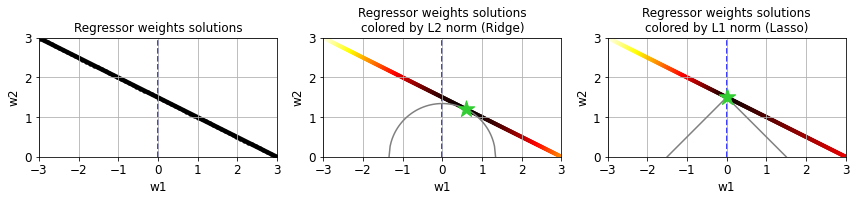

In [5]:
# solution space
w_1 = np.linspace(-3, 3, 301)
w_2 = 1.5 - w_1/2

# norms
l_2_norm = np.sqrt(w_1**2 + w_2**2)
l_1_norm = np.abs(w_1) + np.abs(w_2)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

# weights solution space
axs[0].scatter(w_1, w_2, c='k', s=10)
set_plot(axs[0], x_label='w1', y_label='w2', title='Regressor weights solutions', font_size=12)

# solution space colored by L2 norm
axs[1].scatter(w_1, w_2, c=l_2_norm, cmap='hot', s=10)
# location of minimum
axs[1].scatter(w_1[np.argmin(l_2_norm)], w_2[np.argmin(l_2_norm)], marker='*', c='limegreen', s=300, zorder=10)

# ball of constant L2 norm
l_2_min = l_2_norm.min()
x_circ = np.linspace(-l_2_min, l_2_min, 101)
y_circ = np.sqrt(l_2_min**2 - x_circ**2)
axs[1].plot(x_circ, y_circ, c='gray')

set_plot(axs[1], x_label='w1', y_label='w2', title='Regressor weights solutions\ncolored by L2 norm (Ridge)', font_size=12)

# solution space colored by L1 norm
axs[2].scatter(w_1, w_2, c=l_1_norm, cmap='hot', s=10)
# location of minimum
axs[2].scatter(w_1[np.argmin(l_1_norm)], w_2[np.argmin(l_1_norm)], marker='*', c='limegreen', s=300, zorder=10)

# "ball" of constant L1 norm (diamond)
l_1_min = l_1_norm.min()
x_diam = np.linspace(-l_1_min, l_1_min, 101)
y_diam = np.abs(l_1_min - np.abs(x_diam))
axs[2].plot(x_diam, y_diam, c='gray')

set_plot(axs[2], x_label='w1', y_label='w2', title='Regressor weights solutions\ncolored by L1 norm (Lasso)', font_size=12)

for ax in axs:
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 3)
    ax.axvline(0, color='b', ls='--', zorder=-1)
    ax.set_aspect('equal')
    ax.grid()
    
fig.savefig('20220510_handling_correlated_predictors/norm_geometry.svg')

### Plot total loss landscape for different regularizers

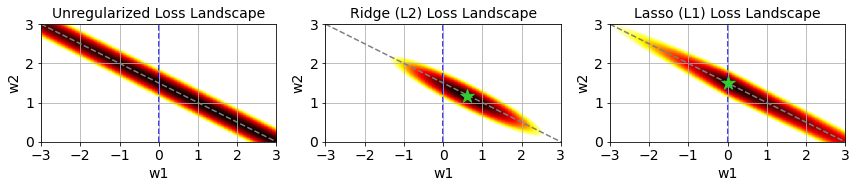

In [6]:
# matrix version of parameter space (weights)
w_1_mat = np.tile(w_1[:, None], (1, len(w_2)))
w_2_mat = np.tile(w_2[None, :], (len(w_1), 1))

# fill in losses
loss = np.zeros(w_1_mat.shape)

for cw_1, w_1_ in enumerate(w_1):
    for cw_2, w_2_ in enumerate(w_2):
        y_hat = w_1_*x_1 + w_2_*x_2
        loss[cw_1, cw_2] = (1/(2*n))*np.sum((y - y_hat)**2)  # note we use our eqns for loss here, not sklearn's
        
l_2_loss = loss + .05*(w_1_mat**2 + w_2_mat**2)  # add weighted L2 norm (squared)
l_1_loss = loss + .05*(np.abs(w_1_mat) + np.abs(w_2_mat))  # add weighted L1 norm

# plot loss landscapes, with coloring scaled to visualize minima
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

# unregularized
axs[0].matshow(loss.T, extent=[-3, 3, 0, 3], vmin=loss.min(), vmax=(loss.min() + .25), cmap='hot')
axs[0].plot([-3, 3], [3, 0], c='gray', ls='--')
set_plot(axs[0], x_label='w1', y_label='w2', title='Unregularized Loss Landscape', font_size=14)

# Ridge (L2)
axs[1].matshow(l_2_loss.T, extent=[-3, 3, 0, 3], vmin=l_2_loss.min(), vmax=(l_2_loss.min() + .25), cmap='hot')
axs[1].scatter(w_1_mat.flatten()[l_2_loss.argmin()], w_2_mat.flatten()[l_2_loss.argmin()], c='limegreen', marker='*', s=200, zorder=5)
axs[1].plot([-3, 3], [3, 0], c='gray', ls='--')
set_plot(axs[1], x_label='w1', y_label='w2', title='Ridge (L2) Loss Landscape', font_size=14)

# Lasso (L1)
axs[2].matshow(l_1_loss.T, extent=[-3, 3, 0, 3], vmin=l_1_loss.min(), vmax=(l_1_loss.min() + .25), cmap='hot')
axs[2].scatter(w_1_mat.flatten()[l_1_loss.argmin()], w_2_mat.flatten()[l_1_loss.argmin()], c='limegreen', marker='*', s=200, zorder=5)
axs[2].plot([-3, 3], [3, 0], c='gray', ls='--')
set_plot(axs[2], x_label='w1', y_label='w2', title='Lasso (L1) Loss Landscape', font_size=14)

for ax in axs:
    ax.xaxis.tick_bottom()
    set_plot(ax, font_size=14)
    ax.axvline(0, color='b', ls='--', zorder=1)
    ax.set_aspect('equal')
    ax.grid()
    
fig.savefig('20220510_handling_correlated_predictors/loss_landscapes.svg')

# Time-series example

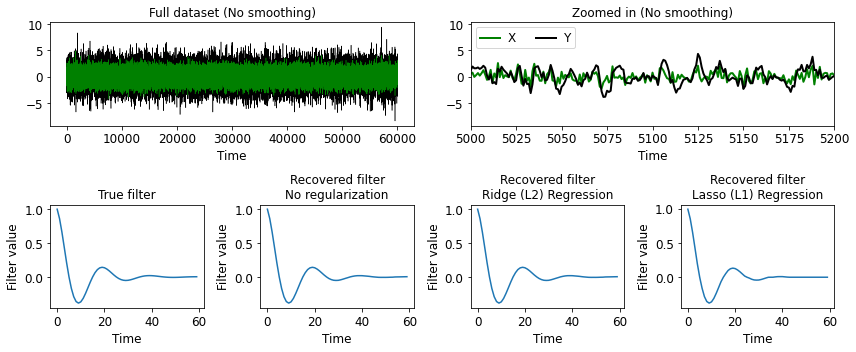

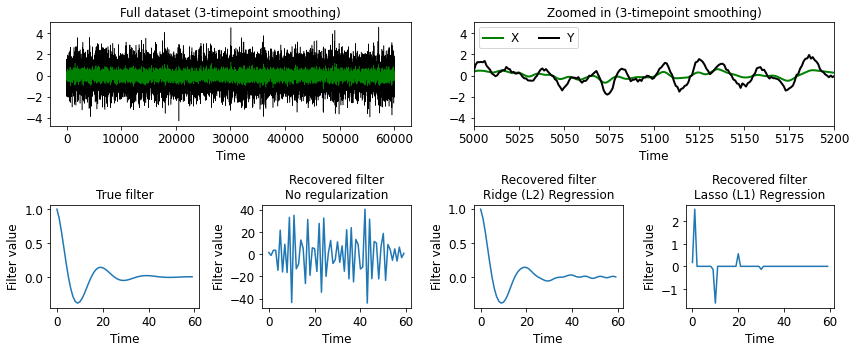

In [7]:
# time-series example
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.signal import convolve
import matplotlib.gridspec as gridspec

# input time-series x
x_white = np.random.randn(60000)

t_h = np.arange(60)  # filter time array
h = np.exp(-t_h/10) * np.cos(2*np.pi*t_h/20)  # filter

for smoothness, label in zip([.1, 3], ['No smoothing', '3-timepoint smoothing']):  # loop over two smoothness values
    x = smooth(x_white, smoothness)  # smooth version of x

    y = convolve(x, h, mode='full')[:len(x)] + .1*np.random.randn(len(x))  # target y
    
    gs = gridspec.GridSpec(2, 4)
    fig = plt.figure(figsize=(12, 5), tight_layout=True)
    axs = [fig.add_subplot(gs[0, :2]), fig.add_subplot(gs[0, 2:])] \
        + [fig.add_subplot(gs[1, col]) for col in range(4)]

    # plot input and target
    ## full
    axs[0].plot(x, c='g', lw=.5)
    axs[0].plot(y, c='k', lw=.5, zorder=0)

    set_plot(axs[0], x_label='Time', title=f'Full dataset ({label})', font_size=12)
    
    ## zoomed in
    axs[1].plot(x, c='g', lw=2)
    axs[1].plot(y, c='k', lw=2)
    axs[1].legend(['X', 'Y'], ncol=2, loc='upper left')

    set_plot(axs[1], x_lim=(5000, 5200), x_label='Time', title=f'Zoomed in ({label})', font_size=12)

    # filter
    axs[2].plot(t_h, h)
    set_plot(axs[2], x_label='Time', y_label='Filter value', title='True filter', font_size=12)

    # convert input to matrix so we can run linear regression
    x_mat = np.nan * np.zeros((len(y), len(t_h)))
    for col in range(x_mat.shape[1]):
        if col == 0:
            x_mat[col:, col] = x
        else:
            x_mat[col:, col] = x[:-col]
            
    mvalid = np.all(~np.isnan(x_mat), axis=1)  # mask for valid (non-nan) rows

    # plot filter recovered by unregularized, ridge, or lasso
    for cax, ax in enumerate(axs[3:], 1):
        if cax == 1:
            h_hat = linear_model.LinearRegression().fit(x_mat[mvalid, :], y[mvalid]).coef_
            name = 'No regularization'

        elif cax == 2:
            h_hat = linear_model.Ridge(alpha=10).fit(x_mat[mvalid, :], y[mvalid]).coef_
            name = 'Ridge (L2) Regression'

        elif cax == 3:
            h_hat = linear_model.Lasso(alpha=.01).fit(x_mat[mvalid, :], y[mvalid]).coef_
            name = 'Lasso (L1) Regression'

        ax.plot(t_h, h_hat)
        set_plot(ax, x_label='Time', y_label='Filter value', title=f'Recovered filter\n{name}', font_size=12)
        
    fig.savefig(f'20220510_handling_correlated_predictors/time_series_smoothness_{smoothness}.svg')